Librerias

In [15]:
using SymPy
using Interpolations
using Plots
using CSV

Datos de temperaturas por Dia

In [16]:
data = CSV.read("temperaturas.csv", DataFrame)
dias = [1.0, 2.0, 3.0, 4.0, 5.0, 6.0, 7.0]
temperaturas = [23.0, 24.0, 25.0, 26.0, 27.0, 22.0, 23.0]

LoadError: ArgumentError: provide a valid sink argument, like `using DataFrames; CSV.read(source, DataFrame)`

Interpolación de Taylor

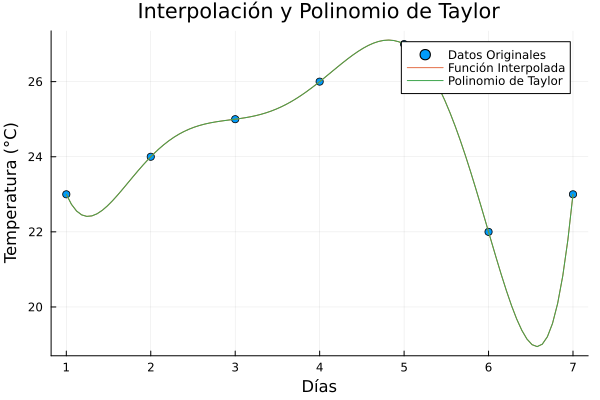

In [ ]:
#Polinomio de Taylor
# Interpolación lineal
funcion_original = LinearInterpolation(dias, temperaturas)

# Definir la variable simbólica x
x = symbols("x")

# Construir la función interpolada
func_interp = 0
for dia in dias
    term = funcion_original[dia]
    for d in dias
        if d != dia
            term *= (x - d) / (dia - d)
        end
    end
    func_interp += term
end

# Parámetros para el polinomio de Taylor
punto = 7
grado_taylor = 7       
n_taylor = grado_taylor + 1  

# Calcular el polinomio de Taylor
polinomio_taylor = 0
for k in 0:n_taylor-1
    derivada_k = diff(func_interp, x, k)
    derivada_punto = subs(derivada_k, x, punto)
    termino_k = (derivada_punto/factorial(k)) * (x - punto)^k
    polinomio_taylor += termino_k
end

# Imprimir el polinomio de Taylor
#println("Polinomio de Taylor de grado $grado_taylor alrededor de x = $punto:", polinomio_taylor)

# Crear funciones para evaluar
func_interp_eval = lambdify(func_interp, [x])
polinomio_taylor_eval = lambdify(polinomio_taylor, [x])

# Crear datos para graficar
x_vals = range(minimum(dias), maximum(dias), length=100)
y_vals_interp = func_interp_eval.(x_vals)
y_vals_taylor = polinomio_taylor_eval.(x_vals)

# Graficar
plot(dias, temperaturas, seriestype=:scatter, label="Datos Originales", markershape=:circle)
plot!(x_vals, y_vals_interp, label="Función Interpolada")
plot!(x_vals, y_vals_taylor, label="Polinomio de Taylor")
xlabel!("Días")
ylabel!("Temperatura (°C)")
title!("Interpolación y Polinomio de Taylor")

Interpolación de Lagrange

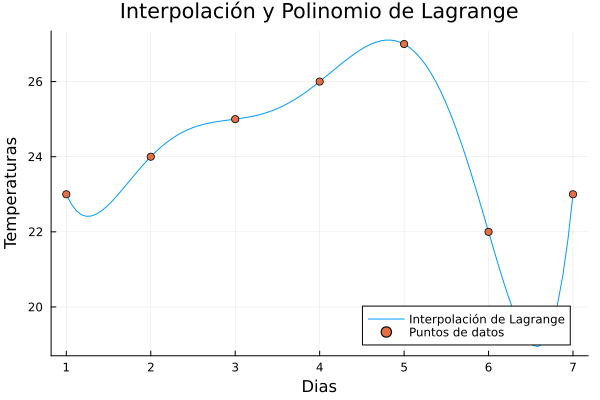

In [ ]:
# Polinomio de Lagrange
n = length(dias)
x = symbols("x")
polinomio = 0
divisorL = zeros(Float64, n)

for i in 1:n
    # Termino de Lagrange
    numerador = 1
    denominador = 1

    for j in 1:n
        if j != i
            numerador *= (x - dias[j])
            denominador *= (dias[i] - dias[j])
        end
    end

    terminoLi = numerador / denominador
    polinomio += terminoLi * temperaturas[i]
    divisorL[i] = denominador
end


# Simplificación del polinomio
polisimple = simplify(polinomio)

# Evaluación numérica
px = lambdify(polinomio, [x])

# Puntos para la gráfica
muestras = 101
a = minimum(dias)
b = maximum(dias)
pdias = range(a, b, length=muestras)
ptemperaturas = px.(pdias)

#println("Temperatura en x = 8 según la función original:", px(8))
# Salida
#println("    valores de temperaturas: ", temperaturas)
#println("divisores en L(i): ", divisorL)
#println()
#println("Polinomio de Lagrange, expresiones")
#println(polinomio)
#println()
#println("Polinomio de Lagrange: ")
#println(polisimple)

# Gráfica
plot(pdias, ptemperaturas, xlabel="Dias", ylabel="Temperaturas", label="Interpolación de Lagrange")
scatter!(dias, temperaturas, label="Puntos de datos", legend=:bottomright)
title!("Interpolación y Polinomio de Lagrange")

Interpolación de Hermite